In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Final Project - Exploring Steam Game Trends and Predicting Optimal Game Prices

## 1. Data Cleaning

1.1 Cleaning the data in applicationInformation.csv. This really the only file outside of PriceHistory, PlayerCountHistory1 and PlayerCountHistory2 that we will be using. It contains the game titles and appid's which are an important part in figuring the prices and player counts.

In [115]:
import pandas as pd
import os.path
import numpy as np

df = pd.read_csv("steam_dataset/applicationInformation.csv",encoding= 'unicode_escape')


for i in df["type"]:
    if(i!='game'):
        df = df[df.type != i]
        
df.dropna(subset=['appid'], inplace=True)
df.dropna(subset=['type'], inplace=True)
df.dropna(subset=['name'], inplace=True)
df.dropna(subset=['releasedate'], inplace=True)
df.dropna(subset=['freetoplay'], inplace=True)
df

,appid,type,name,releasedate,freetoplay
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0
1,570,game,Dota 2,9-Jul-13,1.0
2,730,game,Counter-Strike: Global Offensive,21-Aug-12,1.0
4,359550,game,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0
5,271590,game,Grand Theft Auto V,13-Apr-15,0.0
...,...,...,...,...,...
1993,64000,game,Men of War: Assault Squad,24-Feb-11,0.0
1994,227860,game,Castle Story,17-Aug-17,0.0
1997,429050,game,Feed and Grow: Fish,8-Jan-16,0.0
1998,209650,game,Call of Duty: Advanced Warfare,3-Nov-14,0.0


# 2. Data Integration

2.1 Integrating the data from PriceHistory to our data frame. We just found average price for now and added it to the data frame.

In [116]:
averagePrices = []

for id in df['appid']:
  filename = str(id) + '.csv'
  if os.path.exists(f'steam_dataset/PriceHistory/{filename}'):
    game_price_df = pd.read_csv(f'steam_dataset/PriceHistory/{filename}',encoding= 'unicode_escape')
    totalprice = 0.0
    count = 0
    for price in game_price_df['Finalprice']:
      totalprice+=price
      count+=1
    averagePrices.append(round((totalprice/count), 2))
  else:
    averagePrices.append(0.0)

df['averageprice'] = averagePrices

df

,appid,type,name,releasedate,freetoplay,averageprice
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,27.56
1,570,game,Dota 2,9-Jul-13,1.0,0.00
2,730,game,Counter-Strike: Global Offensive,21-Aug-12,1.0,0.00
4,359550,game,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0,17.08
5,271590,game,Grand Theft Auto V,13-Apr-15,0.0,25.88
...,...,...,...,...,...,...
1993,64000,game,Men of War: Assault Squad,24-Feb-11,0.0,8.82
1994,227860,game,Castle Story,17-Aug-17,0.0,22.63
1997,429050,game,Feed and Grow: Fish,8-Jan-16,0.0,14.88
1998,209650,game,Call of Duty: Advanced Warfare,3-Nov-14,0.0,53.64


2.2 Integrating the data from PlayerCountHistory1 and PlayerCountHistory2 to our data frame. We just found the average player counts for now and added them to our data frame.

In [120]:
averageplayercount = []

for id in df['appid']:
  filename = str(id) + '.csv'
  game_playercount_df = ''
  if os.path.exists(f'steam_dataset/PlayerCountHistoryPart1/{filename}'):
    game_playercount_df = pd.read_csv(f'steam_dataset/PlayerCountHistoryPart1/{filename}')
  elif os.path.exists(f'steam_dataset/PlayerCountHistoryPart2/{filename}'):
    game_playercount_df = pd.read_csv(f'steam_dataset/PlayerCountHistoryPart2/{filename}')
  else:
    averageplayercount.append(0)
    continue
  totalplayers = 0
  count = 0
  game_playercount_df['Playercount'] = game_playercount_df['Playercount'].fillna(0)
  for playercount in game_playercount_df['Playercount']:
    totalplayers+=playercount
    count+=1
  averageplayercount.append(round((totalplayers/count), 2))

df['averageplayercount'] = averageplayercount

df.head(30)

,appid,type,name,releasedate,freetoplay,averageprice,averageplayercount
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,27.56,534928.79
1,570,game,Dota 2,9-Jul-13,1.0,0.00,459574.81
2,730,game,Counter-Strike: Global Offensive,21-Aug-12,1.0,0.00,427094.35
4,359550,game,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0,17.08,74232.19
5,271590,game,Grand Theft Auto V,13-Apr-15,0.0,25.88,74215.78
6,238960,game,Path of Exile,23-Oct-13,1.0,0.00,26815.41
7,230410,game,Warframe,25-Mar-13,1.0,0.00,50398.59
8,440,game,Team Fortress 2,10-Oct-07,1.0,0.00,50453.49
9,252950,game,Rocket League,7-Jul-15,0.0,18.14,35646.51
10,252490,game,Rust,8-Feb-18,0.0,34.55,42847.18


2.3 Add a count column

In [125]:
df['count'] = 1
df.head(30)

,appid,type,name,releasedate,freetoplay,averageprice,averageplayercount,count
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,27.56,534928.79,1
1,570,game,Dota 2,9-Jul-13,1.0,0.00,459574.81,1
2,730,game,Counter-Strike: Global Offensive,21-Aug-12,1.0,0.00,427094.35,1
4,359550,game,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0,17.08,74232.19,1
5,271590,game,Grand Theft Auto V,13-Apr-15,0.0,25.88,74215.78,1
6,238960,game,Path of Exile,23-Oct-13,1.0,0.00,26815.41,1
7,230410,game,Warframe,25-Mar-13,1.0,0.00,50398.59,1
8,440,game,Team Fortress 2,10-Oct-07,1.0,0.00,50453.49,1
9,252950,game,Rocket League,7-Jul-15,0.0,18.14,35646.51,1
10,252490,game,Rust,8-Feb-18,0.0,34.55,42847.18,1


# 3. Data Summary

In [179]:
df.describe()

,appid,freetoplay,averageprice,averageplayercount,count
count,1830.000000,1830.000000,1830.000000,1830.000000,1830.0
mean,337769.546448,0.183060,13.649153,1624.919344,1.0
std,185204.779920,0.386821,13.559868,19661.883826,0.0
min,10.000000,0.000000,0.000000,0.010000,1.0
25%,232020.000000,0.000000,1.842500,32.777500,1.0
50%,339605.000000,0.000000,12.110000,82.915000,1.0
75%,467307.500000,0.000000,18.600000,267.650000,1.0
max,748370.000000,1.000000,158.210000,534928.790000,1.0


# 4. Data Visualization

In [128]:
import matplotlib.pyplot as plt

4.1 Compare the number of free games to the number of paid games. Which category is larger?

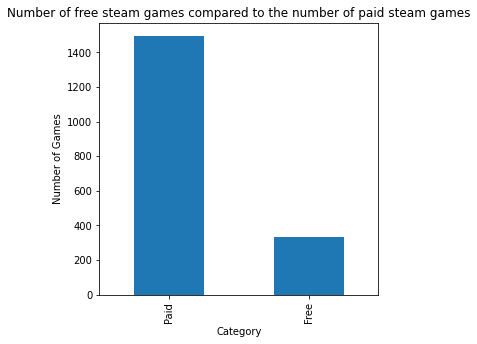

In [139]:
# Group by freetoplay and only look at the count column
free_and_paid = df.groupby('freetoplay').sum()
free_and_paid = free_and_paid['count']

# Plot
plt.subplots(figsize=(5, 5))

free_and_paid.plot.bar()

plt.ylabel('Number of Games')
plt.xlabel('Category')
x = ['Paid', 'Free']
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.title('Number of free steam games compared to the number of paid steam games')
plt.show()

Findings:
- There are a lot more Paid steam games than there are free steam games. One possiblility for this could be due to the fact that developers want to profit off of their hard work instead of letting people use games for free.

4.2 Compare the number of free games to the number of paid games. Which category has more players?

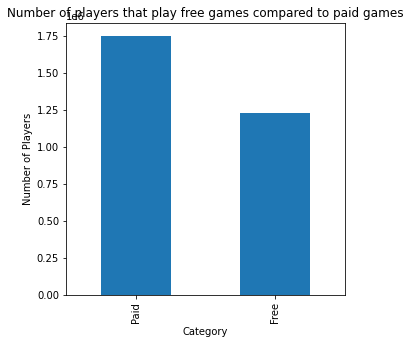

In [140]:
# Group by freetoplay and only look at the averageplayercount column
free_and_paid = df.groupby('freetoplay').sum()
free_and_paid = free_and_paid['averageplayercount']

# Plot
plt.subplots(figsize=(5, 5))

free_and_paid.plot.bar()

plt.ylabel('Number of Players')
plt.xlabel('Category')
x = ['Paid', 'Free']
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.title('Number of players that play free games compared to paid games')
plt.show()

Finidngs: 
- A lot more players use and play paid games than compared to free games. This makes sense because there are a lot more paid games than free games on the steam store. 
- Compared to the significant difference between the number of paid games and the number of free games, there is less of a gap/difference in the number of people who play paid games and the number of people who play free games.

4.3 Compare price of game to number of players.

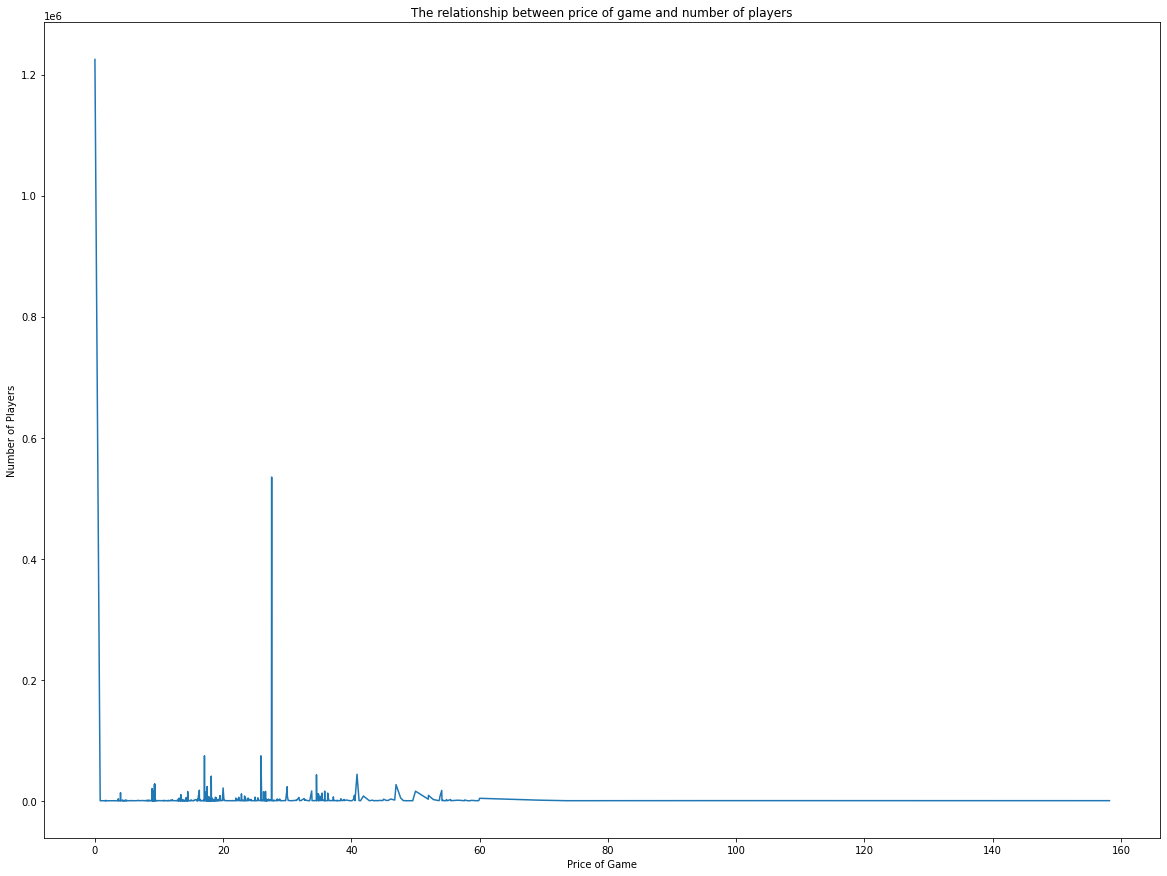

In [157]:
df.sort_values(by='averageprice', ascending=True, inplace=True)

# Group by averageprice and only look at the averageplayercount column
price_and_playercount = df.groupby('averageprice').sum()
price_and_playercount = price_and_playercount['averageplayercount']

# Plot
plt.subplots(figsize=(20, 15))

price_and_playercount.plot()

plt.ylabel('Number of Players')
plt.xlabel('Price of Game')
plt.title('The relationship between price of game and number of players')
plt.show()


Findings:
- The most played games are the games that cost $0.00 (Free).
- The least played games are those that are greater than $60.
- If we exclude free games from this graph the most played games fall in the range of $20-$40. The Most played games cost around $25.

4.4 What are the 5 most played games on steam?

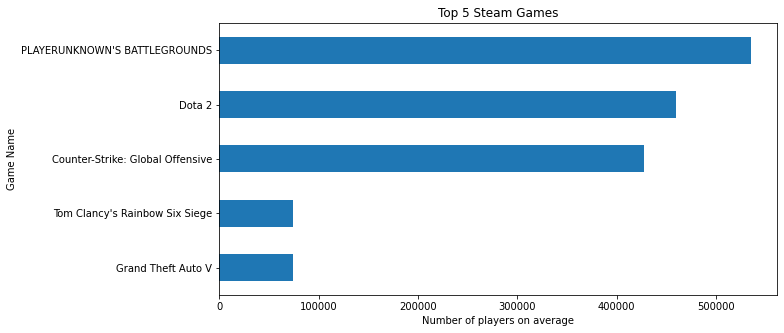

In [177]:
df.sort_values(by='averageplayercount', ascending=False, inplace=True)

top_five_games = df.head(5)
top_five_games = top_five_games.groupby('name').sum()
top_five_games.sort_values(by='averageplayercount', ascending=True, inplace=True)
top_five_games = top_five_games['averageplayercount']

# Plot
plt.subplots(figsize=(10, 5))

top_five_games.plot.barh()

plt.ylabel('Game Title')
plt.xlabel('Number of players on average')
plt.title('Top 5 Steam Games')
plt.show()

4.5 What are the 5 least played games on steam?

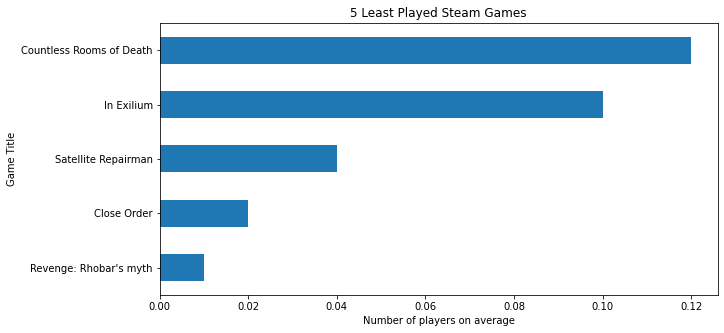

In [178]:
df.sort_values(by='averageplayercount', ascending=True, inplace=True)

lowest_five_games = df.head(5)
lowest_five_games = lowest_five_games.groupby('name').sum()
lowest_five_games.sort_values(by='averageplayercount', ascending=True, inplace=True)
lowest_five_games = lowest_five_games['averageplayercount']

# Plot
plt.subplots(figsize=(10, 5))

lowest_five_games.plot.barh()

plt.ylabel('Game Title')
plt.xlabel('Number of players on average')
plt.title('5 Least Played Steam Games')
plt.show()